In [1]:
spark

In [2]:
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row
import math
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from operator import mul
from operator import add
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
import numpy as np
import pandas as pd
import pyspark.sql.functions as func
%matplotlib inline

In [3]:
week2 = spark.read.parquet("/Users/49132/Documents/big data/tw623-nyu_ml/week2/mortgage_sample")
week4 = spark.read.parquet("/Users/49132/Documents/big data/tw623-nyu_ml/week4/mortgage_sample_week4")


week2.printSchema()
week2.show()

week4.printSchema()
week4.show()

root
 |-- FICO: double (nullable = true)
 |-- CLEANLTV: double (nullable = true)
 |-- INCENTIVE: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- FIRSTTIMEBUYER: double (nullable = true)
 |-- INVESTOR: double (nullable = true)
 |-- SECONDHOME: double (nullable = true)
 |-- SEASON: double (nullable = true)
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)

+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|751.0|    61.0|0.006200000000000004|19.0|           0.0|     0.0|       0.0|  12.0|    1|[751.0,61.0,0.006...|
|751.0|    61.0|0.008200000000000006|20.0|           0.0|     0.0|       0.0|   1.0|    1|[751.0,61.0,0.008...|
|751.0|    61.0|              0.0085|2

In [176]:
#This is the portfolio of your opponent. 
target_portfolio = week4.sample(False,100000/(1.0*week4.count()),seed=832338)
target_portfolio.show()

# This is your target loan. 
target_loan = target_portfolio.limit(1)
target_loan.show()

# The goal is to have your opponent think the target loan is worth very little.
# You will do this by making prob_3 as high as possible. 
# However, if you disrupt the portfolio too much, your opponent will detect the deception. 

# You know the opponent will be using this model
target_fitter = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=6,  maxDepth=8)

# In order to accomplish your goal, you can select any loans from week2 and present them to him as a fitting set.



+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|769.0|    75.0| 0.00279999990016222| 0.0|           0.0|     0.0|       0.0|   9.0|    2|(8,[0,1,2,7],[769...|
|716.0|    78.0|0.001550000044517219|52.0|           0.0|     0.0|       0.0|   8.0|    2|[716.0,78.0,0.001...|
|687.0|    80.0|0.016349999234080315|15.0|           0.0|     0.0|       0.0|   7.0|    2|[687.0,80.0,0.016...|
|780.0|    41.0|0.001200000056996...| 2.0|           0.0|     0.0|       0.0|  12.0|    2|[780.0,41.0,0.001...|
|774.0|    49.0|0.007449999917298555| 7.0|           0.0|     0.0|       0.0|  12.0|    2|[774.0,49.0,0.007...|
|609.0|    90.0|0.004499999806284...| 3.0|           0.0|     0.0|       0.0|   7.0|    2|[609.0,90.0,0.

In [68]:
# First attempt, very limited success. 

#Just take a fair sample. 
target_sample = week2.sample(False,100000/(1.0*week2.count()),seed=1)
opponent_model = target_fitter.fit(target_sample)

predicted_portfolio = opponent_model.transform(target_portfolio)
predicted_portfolio = VectorSlicer(inputCol="probability", outputCol="probability2", indices=[1, 2, 3]).transform(predicted_portfolio)
predicted_loan = predicted_portfolio.limit(1)

def extract(row):
    return (row.FICO,) + tuple(row.probability2.toArray().tolist())

# Maybe consider more than just FICO?
predicted_portfolio = predicted_portfolio.rdd.map(extract).toDF(["FICO","INCENTIVE", "prob_p", "prob_c", "prob_3"])
predicted_portfolio.show()


+-----+--------------------+--------------------+------------------+--------------------+
| FICO|           INCENTIVE|              prob_p|            prob_c|              prob_3|
+-----+--------------------+--------------------+------------------+--------------------+
|769.0| 0.00279999990016222|0.003806941353455885|0.9949691779253663|0.001223880721177...|
|716.0|0.001550000044517219| 0.01234269063278437| 0.984752173243316|0.002905136123899...|
|687.0|0.016349999234080315| 0.08072157811449664|0.9094420836721729|0.009836338213330452|
|780.0|0.001200000056996...|0.004541104526766...|0.9942419458900189|0.001216949583215...|
|774.0|0.007449999917298555| 0.05088391266294259|0.9459987192159897|0.003117368121067...|
|609.0|0.004499999806284...|0.013349108634330501|0.9631279691586272|0.023522922207042232|
|662.0| 0.00430000014603138|  0.0208471632511182|0.9720075830822271|0.007145253666654638|
|762.0| 0.00494999997317791|0.011142391005998552|0.9784898862632149| 0.01036772273078661|
|659.0|0.0

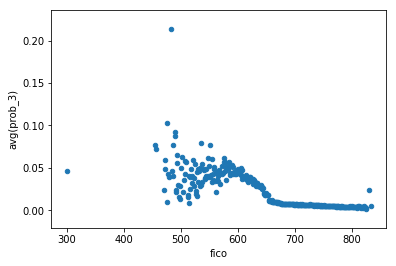

In [37]:

# The portfolio still looks basically fine
grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='avg(prob_3)')


In [31]:
# Unfortunately, prob_3 isn't so high for our target loan. 

predicted_portfolio.limit(1).show()


+-----+--------------------+------------------+--------------------+
| FICO|              prob_p|            prob_c|              prob_3|
+-----+--------------------+------------------+--------------------+
|769.0|0.003806941353455885|0.9949691779253663|0.001223880721177...|
+-----+--------------------+------------------+--------------------+



In [32]:
# Let's try something sneaky

# N.B: I decreased the sample size, because we only have a limited number of poison loans.
target_sample_a = week2.sample(False,10000/(1.0*week2.count()),seed=1)

poison_sample = week2.filter("fico > 765 AND fico < 775 AND label = 3")
poison_sample.show()
target_sample = target_sample_a.unionAll(poison_sample)

#Now do this again.
opponent_model = target_fitter.fit(target_sample)

predicted_portfolio = opponent_model.transform(target_portfolio)
predicted_portfolio = VectorSlicer(inputCol="probability", outputCol="probability2", indices=[1, 2, 3]).transform(predicted_portfolio)

def extract(row):
    return (row.FICO, ) + tuple(row.probability2.toArray().tolist())

predicted_portfolio = predicted_portfolio.rdd.map(extract).toDF(["FICO", "prob_p", "prob_c", "prob_3"])
predicted_loan = predicted_portfolio.limit(1)

# OK, prob_3 got up to 11%, a 100x increase over the previous value. 
predicted_loan.show()

+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|769.0|    80.0|0.023400000000000004|25.0|           0.0|     1.0|       0.0|   4.0|    3|[769.0,80.0,0.023...|
|766.0|    91.0|0.001050000000000...| 1.0|           0.0|     0.0|       0.0|  12.0|    3|[766.0,91.0,0.001...|
|767.0|    75.0|0.010950000000000001|51.0|           0.0|     0.0|       0.0|   7.0|    3|[767.0,75.0,0.010...|
|772.0|    75.0|0.009850000000000005|32.0|           0.0|     0.0|       0.0|  12.0|    3|[772.0,75.0,0.009...|
|767.0|    85.0|              0.0187|21.0|           0.0|     0.0|       0.0|  12.0|    3|[767.0,85.0,0.018...|
|772.0|    79.0|0.013199999999999996|16.0|           0.0|     0.0|       0.0|   1.0|    3|[772.0,79.0,0.

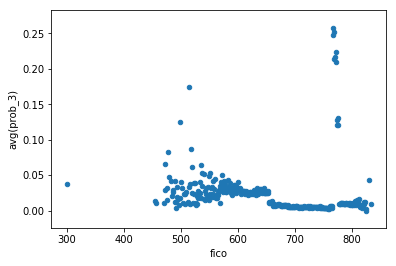

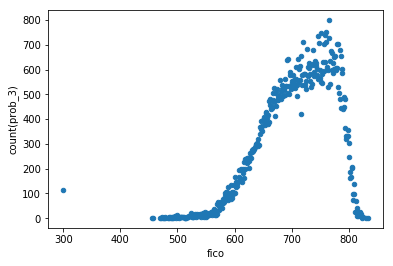

In [33]:
grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))

# Unfortunately, this looks suspicious. We would probably get caught. 
# Is there a better way, so that we can cause similar (though perhaps smaller) impacts without being quite so obvious?
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='avg(prob_3)')
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='count(prob_3)')


In [184]:
# Let's try something sneaky

# N.B: I decreased the sample size, because we only have a limited number of poison loans.
target_sample_a = week2.sample(False,10000/(1.0*week2.count()),seed=1)

poison_sample = week2.filter("fico > 650 AND fico < 700 AND label = 3").limit(50)
poison_sample2 = week2.filter("fico > 700 AND fico < 755 AND label = 3").limit(100)
poison_sample3 = week2.filter("fico >  755 AND fico < 775 AND INCENTIVE > 0.001 AND INCENTIVE < 0.004 AND label = 3").limit(70)
poison_sample4 = week2.filter("fico >  775 AND label = 3").limit(10)
poison_sample = poison_sample.unionAll(poison_sample2)
poison_sample = poison_sample.unionAll(poison_sample3)
poison_sample = poison_sample.unionAll(poison_sample4)


poison_sample.show()
target_sample = target_sample_a.unionAll(poison_sample)

#Now do this again.
opponent_model = target_fitter.fit(target_sample)

predicted_portfolio = opponent_model.transform(target_portfolio)
predicted_portfolio = VectorSlicer(inputCol="probability", outputCol="probability2", indices=[1, 2, 3]).transform(predicted_portfolio)

def extract(row):
    return (row.FICO, row.INCENTIVE) + tuple(row.probability2.toArray().tolist())

predicted_portfolio = predicted_portfolio.rdd.map(extract).toDF(["FICO", "INCENTIVE", "prob_p", "prob_c", "prob_3"])
predicted_loan = predicted_portfolio.limit(1)

# OK, prob_3 got up to 11%, a 100x increase over the previous value. 
predicted_loan.show()

+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|679.0|    80.0|              0.0058| 4.0|           0.0|     0.0|       0.0|   9.0|    3|[679.0,80.0,0.005...|
|679.0|    80.0|0.004799999999999999| 7.0|           0.0|     0.0|       0.0|  12.0|    3|[679.0,80.0,0.004...|
|672.0|    95.0|0.009950000000000007|19.0|           0.0|     0.0|       0.0|  12.0|    3|[672.0,95.0,0.009...|
|670.0|    80.0|0.016349999999999996|19.0|           1.0|     0.0|       0.0|  10.0|    3|[670.0,80.0,0.016...|
|670.0|    80.0|0.019450000000000002|35.0|           1.0|     0.0|       0.0|   2.0|    3|[670.0,80.0,0.019...|
|693.0|    80.0|0.005749999999999991|12.0|           0.0|     0.0|       0.0|   3.0|    3|[693.0,80.0,0.

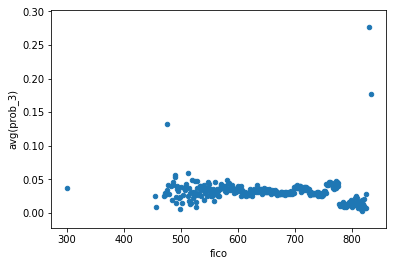

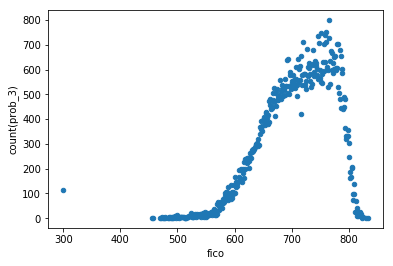

In [185]:
grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))

# Unfortunately, this looks suspicious. We would probably get caught. 
# Is there a better way, so that we can cause similar (though perhaps smaller) impacts without being quite so obvious?
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='avg(prob_3)')
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='count(prob_3)')



+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|769.0|    75.0| 0.00279999990016222| 0.0|           0.0|     0.0|       0.0|   9.0|    2|(8,[0,1,2,7],[769...|
|716.0|    78.0|0.001550000044517219|52.0|           0.0|     0.0|       0.0|   8.0|    2|[716.0,78.0,0.001...|
|687.0|    80.0|0.016349999234080315|15.0|           0.0|     0.0|       0.0|   7.0|    2|[687.0,80.0,0.016...|
|780.0|    41.0|0.001200000056996...| 2.0|           0.0|     0.0|       0.0|  12.0|    2|[780.0,41.0,0.001...|
|774.0|    49.0|0.007449999917298555| 7.0|           0.0|     0.0|       0.0|  12.0|    2|[774.0,49.0,0.007...|
|609.0|    90.0|0.004499999806284...| 3.0|           0.0|     0.0|       0.0|   7.0|    2|[609.0,90.0,0.

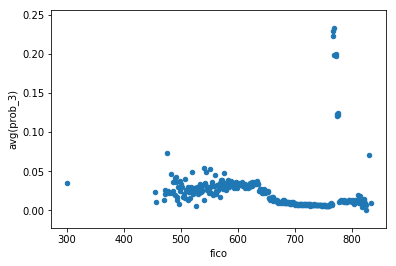

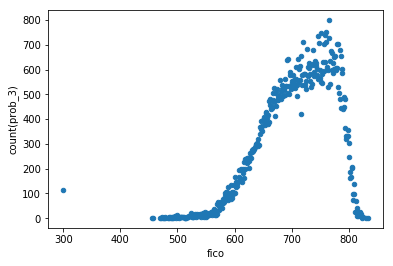

In [175]:
#This is the portfolio of your opponent. 
target_portfolio = week4.sample(False,100000/(1.0*week4.count()),seed=832338)
target_portfolio.show()

# This is your target loan. 
target_loan = target_portfolio.limit(1)
target_loan.show()

# The goal is to have your opponent think the target loan is worth very little.
# You will do this by making prob_3 as high as possible. 
# However, if you disrupt the portfolio too much, your opponent will detect the deception. 

# You know the opponent will be using this model
target_fitter = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10,  maxDepth=8)

# In order to accomplish your goal, you can select any loans from week2 and present them to him as a fitting set.

# Let's try something sneaky

# N.B: I decreased the sample size, because we only have a limited number of poison loans.
target_sample_a = week2.sample(False,10000/(1.0*week2.count()),seed=1)

poison_sample = week2.filter("fico > 765 AND fico < 775 AND label = 3")
poison_sample.show()
target_sample = target_sample_a.unionAll(poison_sample)

#Now do this again.
opponent_model = target_fitter.fit(target_sample)

predicted_portfolio = opponent_model.transform(target_portfolio)
predicted_portfolio = VectorSlicer(inputCol="probability", outputCol="probability2", indices=[1, 2, 3]).transform(predicted_portfolio)

def extract(row):
    return (row.FICO, ) + tuple(row.probability2.toArray().tolist())

predicted_portfolio = predicted_portfolio.rdd.map(extract).toDF(["FICO", "prob_p", "prob_c", "prob_3"])
predicted_loan = predicted_portfolio.limit(1)

# OK, prob_3 got up to 11%, a 100x increase over the previous value. 
predicted_loan.show()
grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))

# Unfortunately, this looks suspicious. We would probably get caught. 
# Is there a better way, so that we can cause similar (though perhaps smaller) impacts without being quite so obvious?
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='avg(prob_3)')
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='count(prob_3)')



+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
| FICO|CLEANLTV|           INCENTIVE| AGE|FIRSTTIMEBUYER|INVESTOR|SECONDHOME|SEASON|label|            features|
+-----+--------+--------------------+----+--------------+--------+----------+------+-----+--------------------+
|769.0|    75.0| 0.00279999990016222| 0.0|           0.0|     0.0|       0.0|   9.0|    2|(8,[0,1,2,7],[769...|
|716.0|    78.0|0.001550000044517219|52.0|           0.0|     0.0|       0.0|   8.0|    2|[716.0,78.0,0.001...|
|687.0|    80.0|0.016349999234080315|15.0|           0.0|     0.0|       0.0|   7.0|    2|[687.0,80.0,0.016...|
|780.0|    41.0|0.001200000056996...| 2.0|           0.0|     0.0|       0.0|  12.0|    2|[780.0,41.0,0.001...|
|774.0|    49.0|0.007449999917298555| 7.0|           0.0|     0.0|       0.0|  12.0|    2|[774.0,49.0,0.007...|
|609.0|    90.0|0.004499999806284...| 3.0|           0.0|     0.0|       0.0|   7.0|    2|[609.0,90.0,0.

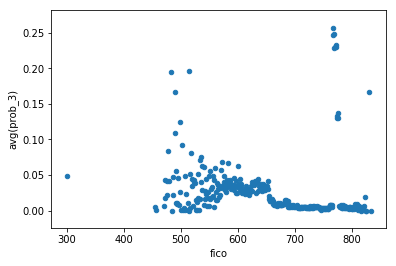

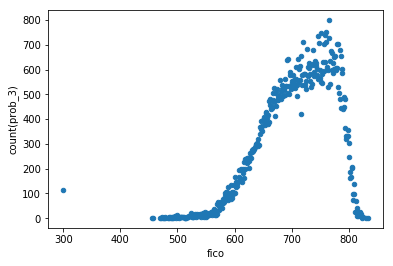

In [162]:
#This is the portfolio of your opponent. 
target_portfolio = week4.sample(False,100000/(1.0*week4.count()),seed=832338)
target_portfolio.show()

# This is your target loan. 
target_loan = target_portfolio.limit(1)
target_loan.show()

# The goal is to have your opponent think the target loan is worth very little.
# You will do this by making prob_3 as high as possible. 
# However, if you disrupt the portfolio too much, your opponent will detect the deception. 

# You know the opponent will be using this model
target_fitter = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=6,  maxDepth=12)

# In order to accomplish your goal, you can select any loans from week2 and present them to him as a fitting set.

# Let's try something sneaky

# N.B: I decreased the sample size, because we only have a limited number of poison loans.
target_sample_a = week2.sample(False,10000/(1.0*week2.count()),seed=1)

poison_sample = week2.filter("fico > 765 AND fico < 775 AND label = 3")
poison_sample.show()
target_sample = target_sample_a.unionAll(poison_sample)

#Now do this again.
opponent_model = target_fitter.fit(target_sample)

predicted_portfolio = opponent_model.transform(target_portfolio)
predicted_portfolio = VectorSlicer(inputCol="probability", outputCol="probability2", indices=[1, 2, 3]).transform(predicted_portfolio)

def extract(row):
    return (row.FICO, ) + tuple(row.probability2.toArray().tolist())

predicted_portfolio = predicted_portfolio.rdd.map(extract).toDF(["FICO", "prob_p", "prob_c", "prob_3"])
predicted_loan = predicted_portfolio.limit(1)

# OK, prob_3 got up to 11%, a 100x increase over the previous value. 
predicted_loan.show()

grouped = predicted_portfolio.groupBy("fico").agg(func.avg("prob_3"), func.count("prob_3"))

# Unfortunately, this looks suspicious. We would probably get caught. 
# Is there a better way, so that we can cause similar (though perhaps smaller) impacts without being quite so obvious?
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='avg(prob_3)')
pd.DataFrame(grouped.collect(), columns=['fico', 'avg(prob_3)', 'count(prob_3)']).plot(kind='scatter', x='fico', y='count(prob_3)')

